# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter to convert the XML data into a tabular format.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema!


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertso2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

Please download the data from https://archive.org/download/stackexchange/english.stackexchange.com.7z and https://archive.org/download/stackexchange/aviation.stackexchange.com.7z into the input folders to run the dashboard. Alternatively, a sample run output has been stored in the respective output folders.


In [93]:
#imports
import warnings
warnings.filterwarnings('ignore')

import os
import os.path

import pandas as pd
import numpy as np
import math
import re
import gensim
from gensim import corpora, models,similarities
from gensim.models import Doc2Vec, TfidfModel
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud

SAMPLE_SIZE = 200000

SITE1 = 'biology' #.stackexchange.com
SITE2 = 'bicycles' #.stackexchange.com
SITES = [SITE1, SITE2]

samples = {}
samples[SITE1] = [
    'Why are the human knees and elbows bent in an opposite direction',
    'How would one determine whether a chemical will upregulate a certain class of proteins?'
]
samples[SITE2] = [
    'Picking a bike for a cyclist new to riding on the road?',
    'max weight that the shimano Rs400 can carry ?'
]

In [48]:
# Global variables
Posts = {}
Dictionaries = {}
Corpora = {}

## 0. Convert Data from XML to CSV

In [49]:
from convertso2csv import process

# To get a new network, do the following
# wget https://archive.org/download/stackexchange/XXX.stackexchange.com.7z  [XXX=chemistry, physics etc]
# Extract the zip into input/XXX folder and then run the command below.

process(os.getcwd() + '/input')

skipping aviation...
skipping english...
skipping biology...
skipping bicycles...


# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

### 1. Load site1 stackexchange data.

In [50]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
Posts[SITE1] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE1]['Tags'] = Posts[SITE1]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE1][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,in prokaryotic translation how critical for e...,what is the criticality of the ribosome bindin...,ribosome binding-sites translation synthet...
1,does anyone have any suggestions to prevent rn...,how is rnase contamination in rna based experi...,rna biochemistry


### 2. Load the site2 stackexchange data.

In [51]:
path = 'output/'+SITE2+'/'+'posts.csv.gz'
Posts[SITE2] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE2]['Tags'] = Posts[SITE2]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE2][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,i keep losing pressure in my tires and among ...,can i use a presta tube in a schrader rim,mountain-bike innertube presta schrader
1,are there adjustments that can be made instead...,what is the easiest way to fix a loose chain,chain


Related data can also be loaded. However, for the purposes of this demonstration, we are not exploiting the data from the tables below.

In [52]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,do you mean measure a frame of unknown dimensi...
1,0,the specified height of a frame i already bou...
2,0,thanks i ll do that
3,2,be sure to bend and flex the casing of the tir...
4,0,what kind of valve i know only very very old...


In [53]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,i was wondering whether you know how critical ...
1,ribosome binding site
3,does anyone have any suggestions to prevent rn...
4,preventing rnase contamination in rna based ex...
6,tortora writes in principles of anatomy and p...


In [54]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,,being an alice in the world of computing can ...
2,new york united states,i m a former stack exchange employee for all...
3,corvallis or,developer on the stack overflow team find me...
4,winston salem nc,stack overflow valued associate twitter nick...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [55]:
class StopWords():
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')

    def remove(self, sentence):
        return [tok for tok in sentence.split() if not tok in self.stop_words and len(tok) > 1]    

In [56]:
class SentenceTokens():
    def __init__(self,df,field):
        self.field = field
        self.df = df
    
    def __iter__(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]
            yield stop_words.remove(raw_sentence)

In [57]:
def get_dictionary(site, posts, force=False):
    dictFile = 'models/' + site + '_posts.dict'

    # Check if trained model file exists
    if ( os.path.isfile(dictFile) and not force):
        dictionary = corpora.Dictionary.load(dictFile)
    else:
        #How frequently each term occurs within each document? We construct a document-term matrix.
        dictionary = corpora.Dictionary(posts)
        dictionary.filter_extremes(no_below=5, no_above=10)
        # store the dictionary, for future reference
        dictionary.save(dictFile) 

    return dictionary

# Bag of words
# corpus is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. 
def get_corpus(site, posts, force=False):
    corpusFile = 'models/' + site + '_posts.mm'
    
    # Check if corpus file is found
    if ( os.path.isfile(corpusFile) and not force ):
        corpus = corpora.MmCorpus(corpusFile)
    else:
        # Create corpus
        corpus = [Dictionaries[site].doc2bow(post) for post in posts]
        
        # Store corpus to file
        corpora.MmCorpus.serialize(corpusFile, corpus) #Save the bow corpus
        
    return corpus

In [58]:
# Create stop words object
stop_words = StopWords() 
forceload = False #Set this to false to avoid computation. Loads the corpus and dictionary from disk.

for site in SITES:
    Dictionaries[site] = get_dictionary(site, SentenceTokens(Posts[site],'Title'), force=forceload)
    Corpora[site] = get_corpus(site, SentenceTokens(Posts[site],'Title'), force=forceload)

## 1. Find out the number of topics
===========================================

We were not aware of the number of topic, so we decided to reduce the number of features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. 

One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [59]:
def get_lsi_model(site, dictionary, corpus, force = False):
    lsimodelFile = 'models/' + site + '_lsi.model'
    
    # Check if corpus file is found
    if ( os.path.isfile(lsimodelFile) and not force):
        lsimodel = models.LsiModel.load(lsimodelFile)
    else:
        # Create model
        # num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        # id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        tfidf = TfidfModel(corpus, normalize=True)
        corpus_tfidf = tfidf[corpus]
        lsimodel = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
        
        # save model to disk (no need to use pickle module)
        lsimodel.save(lsimodelFile)

    return lsimodel   

In [60]:
# Get LSI Model
LsiModels = {}
for site in SITES:
    LsiModels[site] = get_lsi_model(site, Dictionaries[site], Corpora[site], force=True)

We clustered the points in the this reduced space using KMeans, varying the number of clusters (K) from 1 to 10. 
We used the Inertia of the cluster provided by Scikit-Learn KMeans algorithm. 

** Ref ** : http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means


## From the above analysis, we will use number of clusters as 5

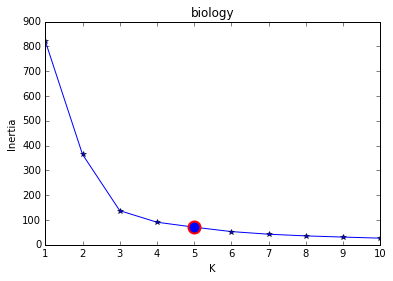

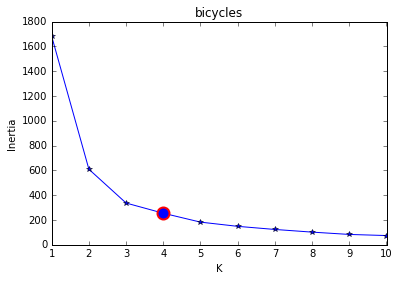

In [61]:
X = {}

for site in SITES:
    D = ''
    for vector in LsiModels[site][Corpora[site]]:
        if 2 == len(vector):
            #'1 2; 3 4' => 2 X 2
            D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'

    X[site] = np.matrix(D[:-1])


    MAX_K = 10
    ks = range(1, MAX_K + 1)

    inertias = np.zeros(MAX_K)
    diff = np.zeros(MAX_K)
    diff2 = np.zeros(MAX_K)
    diff3 = np.zeros(MAX_K)
    for k in ks:
        kmeans = KMeans(k).fit(X[site])
        inertias[k - 1] = kmeans.inertia_
        # first difference    
        if k > 1:
            diff[k - 1] = inertias[k - 1] - inertias[k - 2]
        # second difference
        if k > 2:
            diff2[k - 1] = diff[k - 1] - diff[k - 2]
        # third difference
        if k > 3:
            diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

    elbow = np.argmin(diff3[3:]) + 3

    plt.plot(ks, inertias, "b*-")
    plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
             markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
    plt.ylabel("Inertia")
    plt.xlabel("K")
    plt.title(site)
    plt.show()

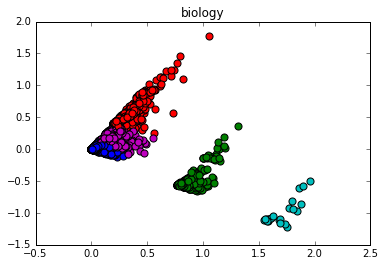

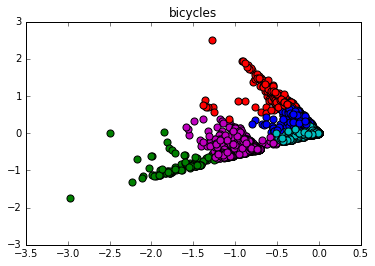

In [62]:
NUM_TOPICS = 5

for site in SITES:
    kmeans = KMeans(NUM_TOPICS).fit(X[site])
    y = kmeans.labels_
    colors = ["b", "g", "r", "m", "c", "p", "y"] #Not expecting more than 5 for the data size
    for i in range(X[site].shape[0]):
        plt.scatter(X[site][i,0] ,X[site][i,1], c=colors[y[i]], s=50)    
    plt.title(site)
    plt.show()

## 2. Sample Search Demonstration
=============================================

In this section, we take a sample question, remove the stop words, and search using the LSI Model just created. We visually inspect the output for correctness.

In [63]:
def QSim(site, document): # Query function for document
    # Apply stop words
    doc_processed = stop_words.remove(document)
    # create vector
    vec_bow = Dictionaries[site].doc2bow(doc_processed)
    # convert the query (sample vector) to LSI space
    vec_lsi = LsiModels[site][vec_bow]
    corpus = Corpora[site]
    # find indexes of similar sims
    index = similarities.MatrixSimilarity(LsiModels[site][corpus]) 
    # perform a similarity query against the corpus
    sims = index[vec_lsi]
    return sims

In [106]:
site = SITE2
target = samples[site][1]
# Search for similar documents
sims = QSim(site,target)
# Sort in descending order - highest matching percentage on top
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sorted_sims))

print("Search results for [{}]:".format(target))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
    print("{:10.3f}% : {}".format(matchPercentage * 100, Posts[site].iloc[docid]['Title']))

Search results for [max weight that the shimano Rs400 can carry ?]:
   100.000% : are there research graphs for the rotor q ring system 
   100.000% : where can i find containers to dispense bulk chain lube
   100.000% : wheel builder london 
   100.000% : how to reinstall a tension screw of a v   brake that been fully unscrewed
   100.000% : the derailer is touching chain and it won t let me go past    speed supposed to go    speeds
   100.000% : crunching grinding chain noise
   100.000% : chain getting stuck between chainrings
   100.000% : how do i calculate the diameter of a chainring from the number of teeth 
   100.000% : will an      chain and cogs wear slower than       chain and cogs for single speed   fixed gear setup 
   100.000% : chain falling off inner chain ring no matter how l screw is set


## 3. Run the entire corpus against LDA to identify topics

The LDA algorithm is run with the number of topics set to the value found in the preceding steps.

In [66]:
def get_lda_model(site, dictionary, corpus, force=False):
    modelFile = 'models/' + site + '_lda.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(modelFile) and not force):
        # load trained model from file
        ldamodel =  models.LdaModel.load(modelFile)
    else:
        # Create model
        
        #num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        #id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        #passes: optional. The number of laps the model will take through corpus.
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word = dictionary, passes=30)

        # save model to disk (no need to use pickle module)
        ldamodel.save(modelFile)

    return ldamodel


In [67]:
# Get LDA Models
LdaModels = {}
for site in SITES:
    LdaModels[site] = get_lda_model(site, Dictionaries[site], Corpora[site], True)

In [84]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def getWordCloud(line):
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    return WordCloud().fit_words(freqs)    

def plotWordCloud(site, num_topics, num_words=6):
    plotId = 1
    figureId = 1    

    for line in LdaModels[site].print_topics(num_topics,num_words):
            if plotId % 2 != 0:            
                plotId = 1
                plt.figure(figureId,figsize=(5*3, 5))

            plt.subplot(120+plotId)
            plt.imshow(getWordCloud(line[1]))
            plt.axis("off")
            plt.title(site + `figureId`)
            plotId += 1
            figureId +=1

    plt.show()

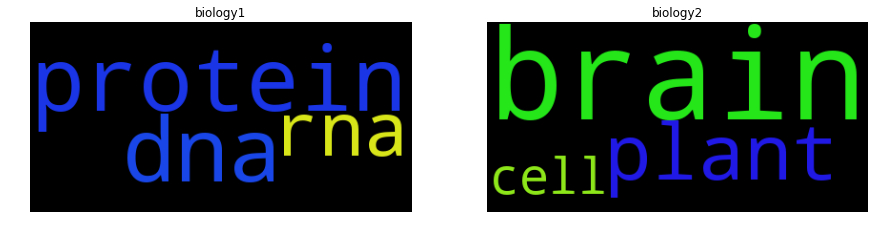

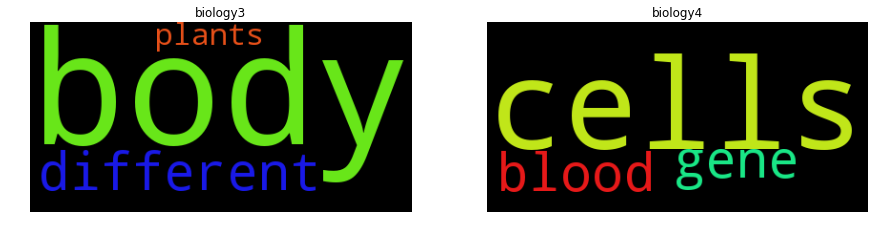

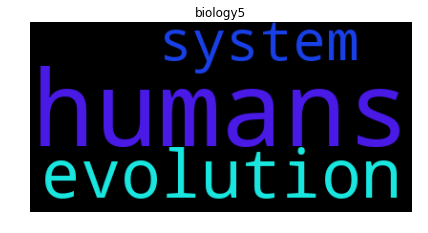

[(0, u'0.034*protein + 0.027*dna + 0.015*rna'),
 (1, u'0.018*brain + 0.017*plant + 0.016*cell'),
 (2, u'0.026*body + 0.023*different + 0.019*plants'),
 (3, u'0.038*cells + 0.027*gene + 0.013*blood'),
 (4, u'0.027*humans + 0.020*evolution + 0.014*system')]

In [85]:
@interact(num_topics=NUM_TOPICS + 5, num_words=3)
def understand(num_topics, num_words):   
   plotWordCloud(SITE1,num_topics,num_words)
   return LdaModels[SITE1].print_topics(num_topics, num_words)

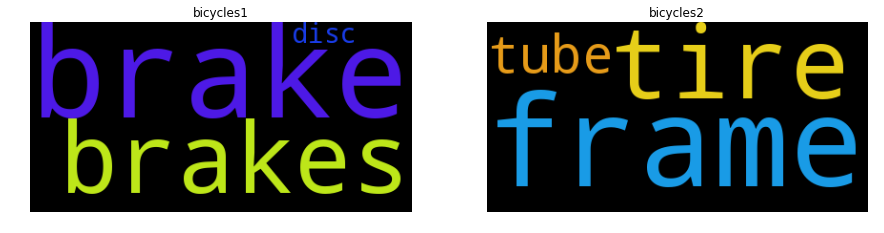

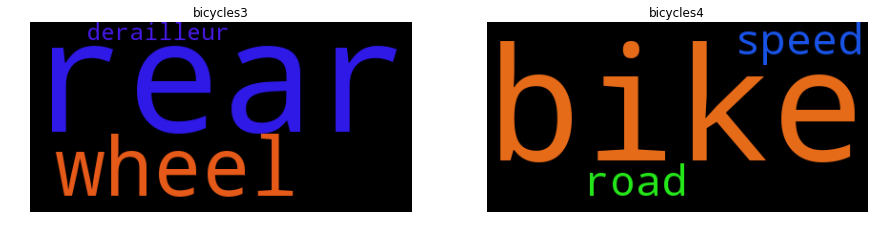

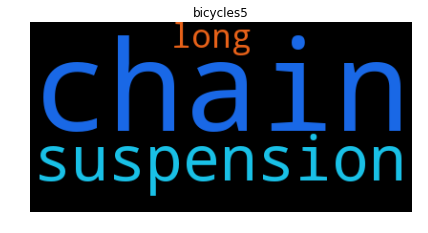

[(0, u'0.062*brake + 0.047*brakes + 0.028*disc'),
 (1, u'0.045*frame + 0.034*tire + 0.023*tube'),
 (2, u'0.052*rear + 0.047*wheel + 0.034*derailleur'),
 (3, u'0.172*bike + 0.045*speed + 0.040*road'),
 (4, u'0.055*chain + 0.021*suspension + 0.018*long')]

In [86]:
@interact(num_topics=NUM_TOPICS + 5, num_words=3)
def understand(num_topics, num_words):
   plotWordCloud(SITE2,num_topics,num_words)
   return LdaModels[SITE2].print_topics(num_topics, num_words)

## 4. Visualize the Model

LDAvis is a web-based interactive visualization of topics estimated using Latent Dirichlet Allocation. The visualization provides a global view of the topics (and how they differ from each other), while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic.

** Ref ** : 2014 ACL Workshop on Interactive Language Learning, Visualization, and Interfaces http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [87]:
#for site in SITES:
site = SITE1
pyLDAvis.gensim.prepare(LdaModels[site],Corpora[site],Dictionaries[site])

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      21.513079        1       1  0.161856 -0.113787
1      21.483416        1       2  0.009446 -0.183797
4      19.302961        1       3 -0.260851  0.176450
2      18.906607        1       4 -0.128390 -0.114864
0      18.793937        1       5  0.217939  0.235997, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
2334  Default  349.000000        cells  349.000000  30.0000  30.0000
1028  Default  279.000000      protein  279.000000  29.0000  29.0000
1860  Default  254.000000         gene  254.000000  28.0000  28.0000
2108  Default  224.000000       humans  224.000000  27.0000  27.0000
1842  Default  211.000000         body  211.000000  26.0000  26.0000
1031  Default  186.000000    different  186.000000  25.0000  25.0000
2090  Default  165.000000    evolution  165.000000  24.0000  24.0000
2093  Default  167.000000        brain  167.000000  23.0000  23.0000
1591  Default  151.000000       plants  151.000000  22.0000  22.0000
1328  Default  154.000000        plant  154.000000  21.0000  21.0000
90    Default  147.000000        would  147.000000  20.0000  20.0000
493   Default  141.000000     possible  141.000000  19.0000  19.0000
492   Default  124.000000          rna  124.000000  18.0000  18.0000
2006  Default  116.000000       system  116.000000  17.0000  17.0000
89    Default  452.000000          dna  452.000000  16.0000  16.0000
1887  Default  175.000000      animals  175.000000  15.0000  15.0000
666   Default  112.000000        genes  112.000000  14.0000  14.0000
1837  Default  330.000000         cell  330.000000  13.0000  13.0000
2221  Default   99.000000   biological   99.000000  12.0000  12.0000
213   Default   94.000000         used   94.000000  11.0000  11.0000
1979  Default  140.000000        cause  140.000000  10.0000  10.0000
1461  Default  136.000000     bacteria  136.000000   9.0000   9.0000
841   Default  167.000000          one  167.000000   8.0000   8.0000
2254  Default   92.000000         like   92.000000   7.0000   7.0000
1364  Default   91.000000         food   91.000000   6.0000   6.0000
1777  Default   89.000000    structure   89.000000   5.0000   5.0000
1422  Default   97.000000       number   97.000000   4.0000   4.0000
1321  Default  246.000000      species  246.000000   3.0000   3.0000
1730  Default   86.000000     question   86.000000   2.0000   2.0000
508   Default   87.000000       people   87.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
970    Topic5   33.477188       behind   34.248577   1.6489  -5.4873
1277   Topic5   33.066398    formation   33.835643   1.6486  -5.4997
1412   Topic5   32.608680   definition   33.379617   1.6483  -5.5136
978    Topic5   32.202086     reaction   32.971641   1.6480  -5.5261
1435   Topic5   31.717923      muscles   32.487956   1.6476  -5.5413
71     Topic5   31.271249        study   32.045209   1.6472  -5.5555
1910   Topic5   31.048896      instead   31.818056   1.6472  -5.5626
2363   Topic5   31.112927     pathways   31.884593   1.6471  -5.5606
20     Topic5   30.738959  replication   31.507314   1.6469  -5.5726
1521   Topic5   29.599364          seq   30.367859   1.6460  -5.6104
210    Topic5   29.563764       spider   30.331960   1.6460  -5.6116
163    Topic5   29.324347        green   30.096933   1.6456  -5.6198
668    Topic5   88.458713        water  119.101767   1.3742  -4.5156
89     Topic5  219.082865          dna  452.963197   0.9453  -3.6087
989    Topic5   75.745968       cancer  110.886914   1.2905  -4.6708
1130   Topic5   59.985230         mean   89.906841   1.2670  -4.9041
1964   Topic5   40.901877      related   55.076621   1.3741  -5.2870
1238   Topic5   39.618590        large   52.045100   1.3988  -5.3189
1605   Topic5   39.382045          gel   52.138310   1.3910 

<img src='images/ldaop.png'> <!-- Only shown as nb does not capture this output -->

# Approach 2 : Doc2Vec
===================================

In [ ]:
class LabeledLineSentence(object):
    def __init__(self,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = stop_words.remove(row[self.field])
            yield doc2vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

In [ ]:
def get_doc2vec(force=False):
    doc2vecFile = 'doc2vec.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(doc2vecFile) and not force):
        # load trained model from file
        docmodel = Doc2Vec.load(doc2vecFile)
    else:
        lablines = LabeledLineSentence(posts,'Title','Id')
        
        # Create model
        docmodel = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
        docmodel.build_vocab(lablines)

        for epoch in range(10):
            docmodel.train(lablines)
            docmodel.alpha -= 0.002  # decrease the learning rate
            docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

        # Save model
        docmodel.save(doc2vecFile)
        
    return docmodel

In [ ]:
docmodel = get_doc2vec()

In [ ]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title        

## Doc2Vec: Sample Search

In [ ]:
def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    print("Search results for [{}]:".format(question))
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles

In [ ]:
# Find similar questions
similarTitles = showsimilar(samples[0])

In [ ]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try T-SNE 
=======================================

In [92]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
tfidf = {}
featurenames = {}
for site in SITES:
    tfidf[site] = tf.fit_transform([p['Title'] for i, p in Posts[site].iterrows()])
    featurenames[site] = tf.get_feature_names() 
#dense = tfidf_matrix.todense()
#len(feature_names)
#feature_names[50:70]

In [95]:
tsne = {}
for site in SITES:
    X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf[site])
    tsne[site] = TSNE(learning_rate=10,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11274
[t-SNE] Computed conditional probabilities for sample 2000 / 11274
[t-SNE] Computed conditional probabilities for sample 3000 / 11274
[t-SNE] Computed conditional probabilities for sample 4000 / 11274
[t-SNE] Computed conditional probabilities for sample 5000 / 11274
[t-SNE] Computed conditional probabilities for sample 6000 / 11274
[t-SNE] Computed conditional probabilities for sample 7000 / 11274
[t-SNE] Computed conditional probabilities for sample 8000 / 11274
[t-SNE] Computed conditional probabilities for sample 9000 / 11274
[t-SNE] Computed conditional probabilities for sample 10000 / 11274
[t-SNE] Computed conditional probabilities for sample 11000 / 11274
[t-SNE] Computed conditional probabilities for sample 11274 / 11274
[t-SNE] Mean sigma: 0.001019
[t-SNE] Iteration 25: error = 1.1038957, gradient norm = 0.0000022
[t-SNE] Iterat

In [ ]:
'''
X_pca = PCA().fit_transform(dense)
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('T-SNE')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
'''

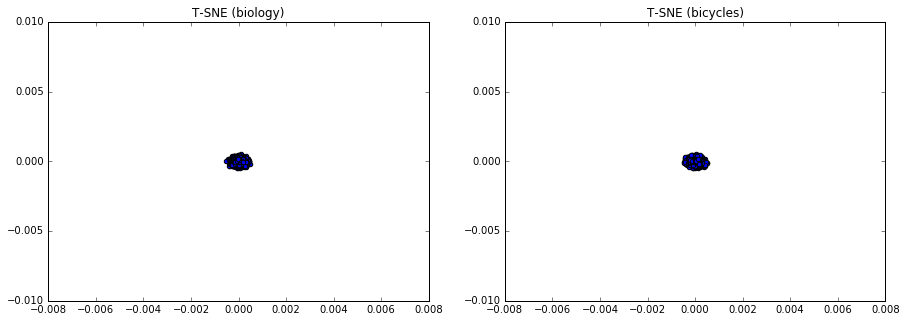

In [105]:
plt.figure(1,figsize=(5*3, 5))
plotId = 1
for site in SITES:
    plt.subplot(120+plotId)
    plt.scatter(tsne[site][:, 0], tsne[site][:, 1])
    plt.title('T-SNE (' + site + ')')
    plotId = plotId + 1

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    